# Random Forest models for all (forecasted danger level) dataset.

### Training of two Random Forest models with the same Hyperparameters but different set of features and snow depth filter

In [1]:
bold_ = '\033[1m'
end_ = '\033[0m'
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters; register_matplotlib_converters()
from sklearn.ensemble import  RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, make_scorer
from sklearn.model_selection import cross_validate
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from matplotlib import pyplot
import pickle

In [2]:
# Read the data
path_file =  '../../data/data_all/'
file =  'Dry_flat_all_mean.csv'
dry_all = pd.read_csv(path_file + file).drop('Unnamed: 0', 1)

In [3]:
def df_train_test(data, features, subset):
    full_df = data.copy()
    full_df.loc[full_df['dangerLevel']==5, 'dangerLevel'] = 4  ## Merge danger level 4 & 5
    ## Filter danger level 4
    full_df.drop(full_df.loc[(full_df['HN72_24_mean'] < 30) & (full_df['dangerLevel'] == 4), 'HN72_24_mean'].index , inplace=True)
    if 'TS2_mean' in features:
        full_df.drop(full_df.loc[(full_df['HS_mod_mean'] < 100), :].index , inplace=True)
        print('TS2 selected')
    else:
        full_df.drop(full_df.loc[(full_df['HS_mod_mean'] < 30), :].index , inplace=True)
        print('TS2 no select')
    full_df = full_df[features + ['datum', 'station_code', 'dangerLevel', 'set']]
    inds = full_df.notna().sum() < 0.8 * full_df['dangerLevel'].notna().sum()  
    print(f'dropping columns because not dense enough: {full_df.loc[:,inds].columns.tolist()}')
    full_df = full_df.drop(full_df.loc[:,inds].columns,axis=1)
    full_df = full_df.dropna() ### Drop NaN
    full_df = full_df.reset_index() 
    full_df = full_df.drop(columns = ['index'])
    if subset == 'Tidy':
        train = full_df[(full_df['set'] == 'train')]
        test = full_df[(full_df['set'] == 'test')]
    elif subset == 'All':
        train = full_df[(full_df['set'] == 'train')| (full_df['set'] == 'validation')]
        test = full_df[(full_df['set'] == 'test')]
    return train, test

## Model 1: RF_all_1 (valid for minimum snow depths of 30 cm)

#### Simplified model: drop of columns 'TS0_mean' (no data in some stations) and  'TS2_mean' (no data in some stations and not valid for snow depths < 100 cm)
#### Dataset filtered for snow depths > 30 cm ### 

In [4]:
set_1 =  ['HN24_mean', 'HN24_mean_7d', 'HN72_24_mean', 'HS_mod_mean', 'ILWR_mean', 'ISWR_dir_mean', 'LWR_net_mean', 
          'MS_Snow_mean', 'Qg0_mean', 'Qs_mean', 'Qw_mean', 'RH_mean', 'S4_mean', 'Sn_mean', 'Ss_mean', 
          'TSS_mod_mean', 'TA_mean',  'VW_drift_mean', 'VW_mean', 'pAlbedo_mean',  'wind_trans24_mean', 
          'wind_trans24_mean_3d', 'wind_trans24_mean_7d',  'zSn_mean',
          'crit_cut_length_weak_100', 'min_ccl_pen', 'pen_depth', 'sn38_weak_100'] 

In [5]:
rf = RandomForestClassifier(class_weight='balanced', max_depth=50,
                       max_features='log2', min_samples_leaf=6, n_jobs = -1,
                       min_samples_split=12, n_estimators=1000,
                       random_state=42)

In [6]:
feat_select = set_1
train, test = df_train_test(dry_all, feat_select, 'All')
Xtrn = train[feat_select]
Ytrn = train['dangerLevel']
Xtest = test[feat_select]
Ytest = test['dangerLevel']

TS2 no select
dropping columns because not dense enough: []


Text(0.5, 1.0, 'Danger level distribution: Train dataset')

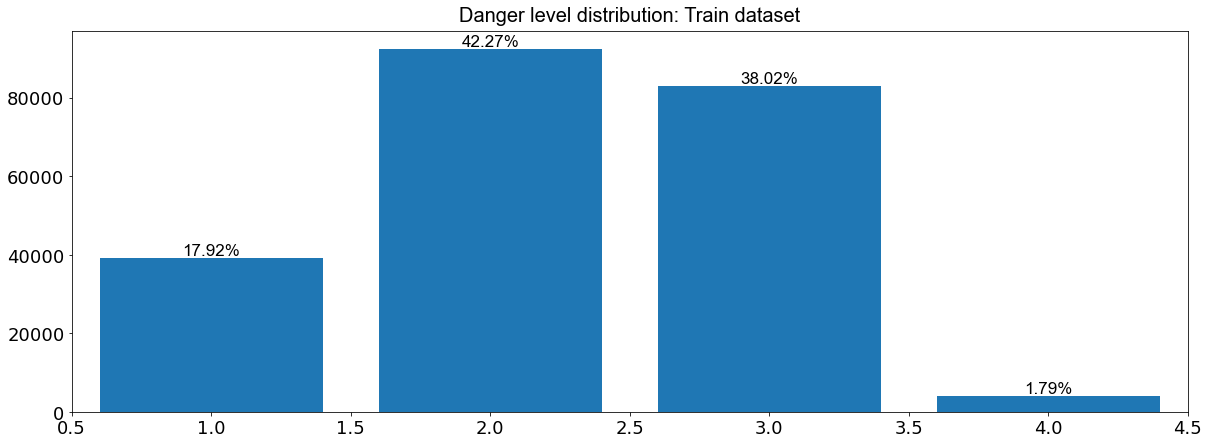

In [11]:
title_font = {'fontname':'Arial', 'size':'20', 'color':'black', 'weight':'normal','verticalalignment':'bottom'}
title2_font = {'fontname':'Arial', 'size':'17', 'color':'black', 'weight':'normal','verticalalignment':'bottom'}
plt.figure(figsize=(20, 7))
dl_un, dl_counts =  np.unique(train['dangerLevel'].dropna(),return_counts=True) 
_tot = np.sum(dl_counts)
params = {'axes.titlesize':'18',
          'xtick.labelsize':'18',
          'ytick.labelsize':'18'}
matplotlib.rcParams.update(params)
bar = plt.bar(range(1,5,1),dl_counts)
plt.xlim([0.5, 4.5])
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, f'{np.round(height/_tot*100, decimals=2)}%', ha='center', va='bottom',  **title2_font)
#plt.ylim(0, 5100)
plt.title('Danger level distribution: Train dataset', **title_font)

Text(0.5, 1.0, 'Danger level distribution: Test dataset')

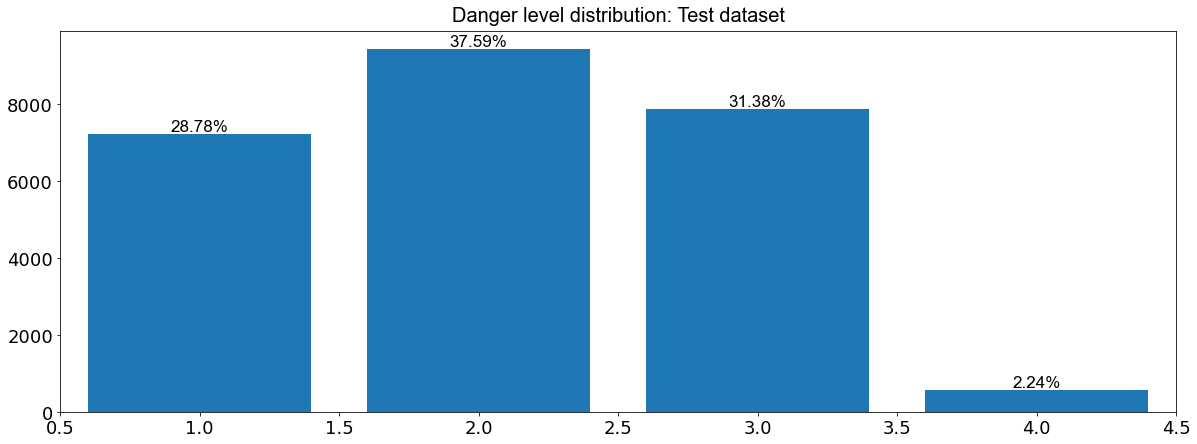

In [12]:
title_font = {'fontname':'Arial', 'size':'20', 'color':'black', 'weight':'normal','verticalalignment':'bottom'}
title2_font = {'fontname':'Arial', 'size':'17', 'color':'black', 'weight':'normal','verticalalignment':'bottom'}
plt.figure(figsize=(20, 7))
dl_un, dl_counts =  np.unique(test['dangerLevel'].dropna(),return_counts=True) 
_tot = np.sum(dl_counts)
params = {'axes.titlesize':'18',
          'xtick.labelsize':'18',
          'ytick.labelsize':'18'}
matplotlib.rcParams.update(params)
bar = plt.bar(range(1,5,1),dl_counts)
plt.xlim([0.5, 4.5])
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, f'{np.round(height/_tot*100, decimals=2)}%', ha='center', va='bottom',  **title2_font)
#plt.ylim(0, 5100)
plt.title('Danger level distribution: Test dataset', **title_font)

In [14]:
model1 = rf.fit(Xtrn, Ytrn)
Ytr_hat = model1.predict(Xtrn)
Ytest_hat = model1.predict(Xtest)
report_test = classification_report(Ytest,Ytest_hat)
print(f'{bold_}### TEST{end_}')
print(report_test)
report_tr = classification_report(Ytrn,Ytr_hat)
print(f'{bold_}### TRN{end_}')
print(report_tr)

### TEST
              precision    recall  f1-score   support

           1       0.78      0.80      0.79      7209
           2       0.68      0.64      0.66      9416
           3       0.72      0.77      0.74      7861
           4       0.62      0.51      0.56       561

    accuracy                           0.72     25047
   macro avg       0.70      0.68      0.69     25047
weighted avg       0.72      0.72      0.72     25047

### TRN
              precision    recall  f1-score   support

           1       0.83      0.96      0.89     39100
           2       0.91      0.87      0.89     92259
           3       0.92      0.88      0.90     82969
           4       0.72      1.00      0.84      3915

    accuracy                           0.89    218243
   macro avg       0.84      0.93      0.88    218243
weighted avg       0.89      0.89      0.89    218243



In [15]:
print(list(Xtrn), len(Xtrn.columns), len(Xtrn))

['HN24_mean', 'HN24_mean_7d', 'HN72_24_mean', 'HS_mod_mean', 'ILWR_mean', 'ISWR_dir_mean', 'LWR_net_mean', 'MS_Snow_mean', 'Qg0_mean', 'Qs_mean', 'Qw_mean', 'RH_mean', 'S4_mean', 'Sn_mean', 'Ss_mean', 'TSS_mod_mean', 'TA_mean', 'VW_drift_mean', 'VW_mean', 'pAlbedo_mean', 'wind_trans24_mean', 'wind_trans24_mean_3d', 'wind_trans24_mean_7d', 'zSn_mean', 'crit_cut_length_weak_100', 'min_ccl_pen', 'pen_depth', 'sn38_weak_100'] 28 218243


In [16]:
### Save the model:
filename = 'RF_all_1.sav'
pickle.dump(model1, open(filename, 'wb'))